<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/monaiDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

In [1]:
!pip install monai

     |████████████████████████████████| 721 kB 5.0 MB/s 


In [2]:
# !pip uninstall monai
# !pip uninstall monai-weekly

In [3]:
!python -c "import monai" 
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [4]:

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL #pillow
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
# from monai.transforms.io.array import LoadPNG
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    Resize,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    AsChannelFirst, 
    EnsureType,
    Resized
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.8.1
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [6]:
root_dir = '/content'
print(root_dir)

/content


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# uncomment the code below to recreate resized data
!rm -r /content/drive/MyDrive/cancer_dataG-resized

rm: cannot remove '/content/drive/MyDrive/cancer_dataG-resized': No such file or directory


In [10]:

# read and resize all images
from PIL import Image
import os, sys

path = "/content/drive/MyDrive/cancer_dataG"
dirs = os.listdir(path)
outPath = "/content/drive/MyDrive/cancer_dataG-resized-224"
target_size = (224, 224)
if not os.path.exists(outPath):
  os.mkdir(outPath)
  for item in dirs:
      class_path = os.path.join(path, item)
      os.mkdir(os.path.join(outPath, item))
      for im in os.listdir(class_path):
            im_path = os.path.join(class_path, im)
            img = Image.open(im_path)
            imResize = img.resize(target_size, Image.ANTIALIAS)
            #print(os.path.join(outPath, im_path))
            imResize.save(os.path.join(outPath, item, im), 'PNG', quality=90)
else:
  print('Path Already Exists.')


In [14]:
data_dir = "/content/drive/MyDrive/cancer_dataG-resized-224"

## Set deterministic training for reproducibility

In [15]:
set_determinism(seed=0)

## Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics.  
There are 3 folders in the dataset: Stage 1, Satge 2, Stage 3, which should be used as the labels to train our classification model.

In [17]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 750
Image dimensions: 224 x 224
Label names: ['stage_1_png', 'stage_2_png', 'stage_3_png']
Label counts: [250, 250, 250]


In [18]:
data_df = pd.DataFrame({'image_path':image_files_list, 'class_name':image_class})

In [19]:
data_df

,image_path,class_name
0,/content/drive/MyDrive/cancer_dataG-resized-22...,0
1,/content/drive/MyDrive/cancer_dataG-resized-22...,0
2,/content/drive/MyDrive/cancer_dataG-resized-22...,0
3,/content/drive/MyDrive/cancer_dataG-resized-22...,0
4,/content/drive/MyDrive/cancer_dataG-resized-22...,0
...,...,...
745,/content/drive/MyDrive/cancer_dataG-resized-22...,2
746,/content/drive/MyDrive/cancer_dataG-resized-22...,2
747,/content/drive/MyDrive/cancer_dataG-resized-22...,2
748,/content/drive/MyDrive/cancer_dataG-resized-22...,2


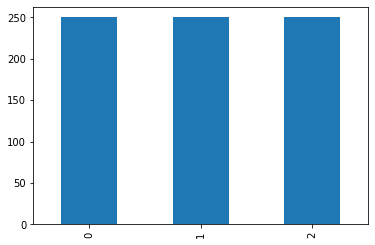

In [20]:
data_df.class_name.value_counts().plot.bar()
plt.show()

## Randomly pick images from the dataset to visualize and check

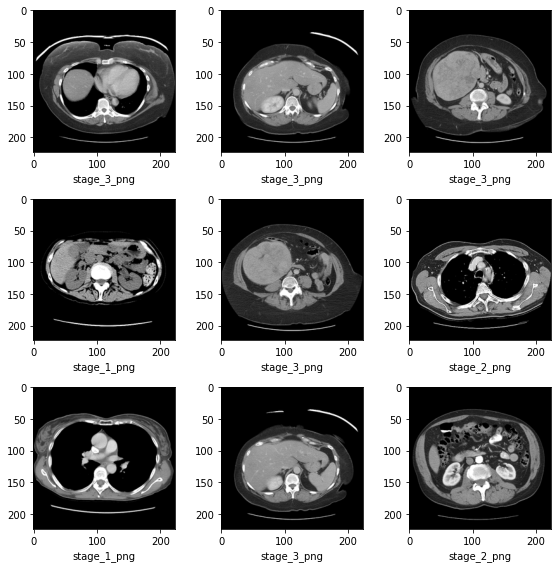

In [21]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists

Randomly select 10% of the dataset as validation and 10% as test.

In [22]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

# we are get the indices for testing/val
test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 600, Validation count: 75, Test count: 75


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [24]:
train_transforms = Compose(
    [
        # Data processing for training
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

# Data processing for val/test
val_transforms = Compose(
    [LoadImage(image_only=True), AddChannel(), ScaleIntensity(), EnsureType()]
)

# used on output of the model
y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=num_class)])

In [25]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

# Batch size defines the number of samples that will be propagated through the network
# num_workers = number of threads/jobs done 
train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=16, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=16, num_workers=2)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=16, num_workers=2)

In [26]:
train_ds.__getitem__(1)[0].shape

torch.Size([1, 224, 224])

## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
And as this is just a get start tutorial, let's just train 4 epochs.  
If train 10 epochs, the model can achieve 100% accuracy on test dataset. 
1. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

In [27]:
from torchsummary import summary

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 10
val_interval = 1
auc_metric = ROCAUCMetric()

In [29]:
summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]           8,192
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]          36,864
      _DenseLayer-11           [-1, 96, 16, 16]               0
      BatchNorm2d-12           [-1, 96, 16, 16]             192
             ReLU-13           [-1, 96, 16, 16]               0
           Conv2d-14          [-1, 128,

## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation accuracy.

In [30]:
torch.cuda.empty_cache()


In [31]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    # train
    model.train()
    epoch_loss = 0
    step = 0
    # optimizing loss function with grad_des
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # validation, and prints the results of each epoch
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/10
1/37, train_loss: 1.1380
2/37, train_loss: 1.0969
3/37, train_loss: 1.0495
4/37, train_loss: 1.1229
5/37, train_loss: 1.0956
6/37, train_loss: 1.0628
7/37, train_loss: 1.0596
8/37, train_loss: 1.0556
9/37, train_loss: 1.0936
10/37, train_loss: 1.0481
11/37, train_loss: 1.0937
12/37, train_loss: 1.0714
13/37, train_loss: 1.0504
14/37, train_loss: 1.0394
15/37, train_loss: 1.0256
16/37, train_loss: 1.0141
17/37, train_loss: 1.0250
18/37, train_loss: 1.0504
19/37, train_loss: 1.0289
20/37, train_loss: 1.0289
21/37, train_loss: 0.9718
22/37, train_loss: 0.9758
23/37, train_loss: 1.0130
24/37, train_loss: 0.9865
25/37, train_loss: 0.9854
26/37, train_loss: 0.9432
27/37, train_loss: 0.9867
28/37, train_loss: 0.9798
29/37, train_loss: 1.0190
30/37, train_loss: 1.0089
31/37, train_loss: 1.0138
32/37, train_loss: 0.9539
33/37, train_loss: 0.9655
34/37, train_loss: 0.9107
35/37, train_loss: 0.9149
36/37, train_loss: 0.9816
37/37, train_loss: 0.9579
38/37, train_loss: 0.9689

In [32]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  116920 KB |    2122 MB |    2201 GB |    2201 GB |
|       from large pool |   16000 KB |    2011 MB |    2143 GB |    2143 GB |
|       from small pool |  100920 KB |     151 MB |      58 GB |      58 GB |
|---------------------------------------------------------------------------|
| Active memory         |  116920 KB |    2122 MB |    2201 GB |    2201 GB |
|       from large pool |   16000 KB |    2011 MB |    2143 GB |

## Plot the loss and metric

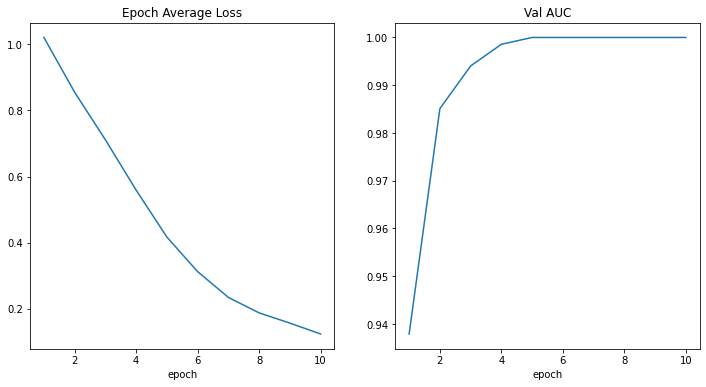

In [33]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

After training and validation, we already got the best model on validation test.  
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.  
We'll use these predictions to generate a classification report.

In [34]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [35]:
# weighted avg = AVG(total true predictions for each class / images in that class) - AVG(250/250) 
# macro avg = 3 classes --> 3 pairs of 2 classes, 
# accuracy = total true predictions / total images (750/750)
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

 stage_1_png     1.0000    1.0000    1.0000        22
 stage_2_png     1.0000    1.0000    1.0000        28
 stage_3_png     1.0000    1.0000    1.0000        25

    accuracy                         1.0000        75
   macro avg     1.0000    1.0000    1.0000        75
weighted avg     1.0000    1.0000    1.0000        75

